In [1]:
import sys
sys.path.append('../../astro_tools')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import ImageGrid
from reproject import reproject_interp
from astropy import units as u
from matplotlib.lines import Line2D
# from astropy.visualization.wcsaxes import add_beam, add_scalebar
from spectral_cube import SpectralCube
import cmasher as cmr

from convolution import gauss_2d_kernel
from astropy.convolution import Gaussian2DKernel, Box2DKernel, convolve, interpolate_replace_nans

# set up the plot
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_offset(dat, w):
    
    center_pix = w.pixel_to_world(dat.shape[1]//2, dat.shape[0]//2)
    
    ra_hr = center_pix.ra.hms[0]
    ra_min = center_pix.ra.hms[1]
    ra_sec = center_pix.ra.hms[2]
    ra_hms = '%s$^{h}$%s$^{m}$%s$^{s}$' % (int(ra_hr), int(ra_min), np.round(ra_sec,2))
    
    dec_deg = center_pix.dec.dms[0]
    dec_min = center_pix.dec.dms[1]
    dec_sec = center_pix.dec.dms[2]
    dec_dms = "%s$^{o}$%s'%s''" % (int(dec_deg), int(np.abs(dec_min)), np.round(np.abs(dec_sec),2))

    return(ra_hms, dec_dms)

Set variables.

In [7]:
num_obs = 150
free_params1 = 6
free_params2 = 12
free_params3 = 18
savepath1 = '../../ngc253/muse/Nov28/fits1_total/'
savepath2 = '../../ngc253/muse/Nov28/fits2_total/'
savepath3 = '../../ngc253/muse/Nov28/fits3_total/'
infile1 = '%sfits1_reordered.txt' % savepath1
infile2 = '%sfits2_reordered.txt' % savepath2
infile3 = '%sfits3_reordered.txt' % savepath3
ERRinfile1 = '%sfits1_err_reordered.txt' % savepath1
ERRinfile2 = '%sfits2_err_reordered.txt' % savepath2
ERRinfile3 = '%sfits3_err_reordered.txt' % savepath3

fits1 = pd.read_csv(infile1)
fits2 = pd.read_csv(infile2)
fits3 = pd.read_csv(infile3)
ERRfits1 = pd.read_csv(ERRinfile1)
ERRfits2 = pd.read_csv(ERRinfile2)
ERRfits3 = pd.read_csv(ERRinfile3)

# get info of original data
og = '../../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits'
hdu = fits.open(og)[1]
og_data = hdu.data
y, x = og_data[1].shape
print(y,x)
w = wcs.WCS(hdu.header, naxis=2).celestial

# open the BIC_PHYS test fits file
which_model_infile = '../../ngc253/muse/Nov28/BIC_PHYS_RATIO_1p5.fits'
hdu_BIC = fits.open(which_model_infile)
which_model = hdu_BIC[0].data

# open the disk velocity model
disk_map_infile = '../../ngc253/muse/data/ngc253_se_halpha_vel_model_smooth_replaceCO_andsmooth.fits'
hdu_Ha = fits.open(disk_map_infile)
disk_map = hdu_Ha[0].data
print(disk_map.shape)

# disk_map_infile = '../../ngc253/data/Krieger19_CO_velocity_ngc253_vsys_barycentric.fits'
# hdu_CO = fits.open(disk_map_infile)
# disk_map = hdu_CO[0].data
# print(disk_map.shape)

pd.set_option('display.max_columns', 500)

436 437
(436, 437)


In [31]:
fits2[(fits2['X'] == 125) & (fits2['Y'] == 106)]
fits3[(fits3['X'] == 144) & (fits2['Y'] == 133)]

,X,Y,RedChiSq,Amp1,Amp2,Amp3,Amp4,Amp5,Amp6,Amp7,Amp8,Amp9,Amp10,Amp11,Amp12,Amp13,Amp14,Amp15,Wvl1,Wvl2,Wvl3,Wvl4,Wvl5,Wvl6,Wvl7,Wvl8,Wvl9,Wvl10,Wvl11,Wvl12,Wvl13,Wvl14,Wvl15,Sig1,Sig2,Sig3,Sig4,Sig5,Sig6,Sig7,Sig8,Sig9,Sig10,Sig11,Sig12,Sig13,Sig14,Sig15,Vel1,Vel2,Vel3,Vel4,Vel5,Vel6,Vel7,Vel8,Vel9,Vel10,Vel11,Vel12,Vel13,Vel14,Vel15,SigVel1,SigVel2,SigVel3,SigVel4,SigVel5,SigVel6,SigVel7,SigVel8,SigVel9,SigVel10,SigVel11,SigVel12,SigVel13,SigVel14,SigVel15,rms,BIC
20669,144,133,0.8694,19.1445,2.9544,38.702,24.9857,285.0209,28.7609,57.4336,116.1061,116.1061,19.243,58.2933,12.1175,0.0,36.6902,13.2417,6546.4078,6553.2419,6556.7931,6561.1551,6568.0046,6571.5638,6581.7989,6588.67,6592.2404,6714.7555,6721.7655,6725.408,6729.1319,6736.1569,6739.8072,1.2332,1.1554,1.8957,1.2332,1.1554,1.8957,1.2332,1.1554,1.8957,1.2332,1.1554,1.8957,1.2332,1.1554,1.8957,-325.347285,-5.246895,161.086712,-325.347311,-5.246706,161.086906,-325.348308,-5.245423,161.088256,-325.35044,-5.243022,161.089542,-325.350142,-5.243112,161.089514,56.499263,52.934843,86.851811,56.372272,52.815863,86.656597,56.19546,52.650206,86.384798,55.082752,51.607697,84.674322,54.965071,51.49744,84.49342,10.635443,204.952235


Get everything into numpy arrays! Working with Halpha.

In [18]:
BIC_map1 = np.full((y,x), np.nan)
BIC_map2 = np.full((y,x), np.nan)
BIC_map3 = np.full((y,x), np.nan)
redchisq_map1 = np.full((y,x), np.nan)
redchisq_map2 = np.full((y,x), np.nan)
redchisq_map3 = np.full((y,x), np.nan)
amp_map1 = np.full((y,x), np.nan)
amp_map2_b = np.full((y,x), np.nan)
amp_map2_r = np.full((y,x), np.nan)
amp_map3_b = np.full((y,x), np.nan)
amp_map3_0 = np.full((y,x), np.nan)
amp_map3_r = np.full((y,x), np.nan)
vel_map1 = np.full((y,x), np.nan)
vel_map2_b = np.full((y,x), np.nan)
vel_map2_r = np.full((y,x), np.nan)
vel_map3_b = np.full((y,x), np.nan)
vel_map3_0 = np.full((y,x), np.nan)
vel_map3_r = np.full((y,x), np.nan)
sig_map1 = np.full((y,x), np.nan)
sig_map2_b = np.full((y,x), np.nan)
sig_map2_r = np.full((y,x), np.nan)
sig_map3_b = np.full((y,x), np.nan)
sig_map3_0 = np.full((y,x), np.nan)
sig_map3_r = np.full((y,x), np.nan)

# make maps of the BICs, velocities, and FWHMs
for index, row in fits1.iterrows():
    redchisq_map1[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map1[int(row['Y']), int(row['X'])] = row['BIC']
    amp_map1[int(row['Y']), int(row['X'])] = row['Amp2']
    
    if row['Amp2'] == 0.0:  # for some reason, it recorded where vels where amp == 0
        vel_map1[int(row['Y']), int(row['X'])] = np.nan
        sig_map1[int(row['Y']), int(row['X'])] = np.nan
    else:
        vel_map1[int(row['Y']), int(row['X'])] = row['Vel2']
        sig_map1[int(row['Y']), int(row['X'])] = row['SigVel2'] 
        
for index, row in fits2.iterrows():
    redchisq_map2[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map2[int(row['Y']), int(row['X'])] = row['BIC']
    amp_map2_b[int(row['Y']), int(row['X'])] = row['Amp3']
    amp_map2_r[int(row['Y']), int(row['X'])] = row['Amp4']
    
    if row['Amp3'] == 0.0:  # for some reason, it recorded where vels where amp == 0
        vel_map2_b[int(row['Y']), int(row['X'])] = np.nan
        sig_map2_b[int(row['Y']), int(row['X'])] = np.nan
    else:
        vel_map2_b[int(row['Y']), int(row['X'])] = row['Vel3']
        sig_map2_b[int(row['Y']), int(row['X'])] = row['SigVel3']
        
    if row['Amp4'] == 0.0:  # for some reason, it recorded where vels where amp == 0
        vel_map2_r[int(row['Y']), int(row['X'])] = np.nan
        sig_map2_r[int(row['Y']), int(row['X'])] = np.nan
    else:
        vel_map2_r[int(row['Y']), int(row['X'])] = row['Vel4']
        sig_map2_r[int(row['Y']), int(row['X'])] = row['SigVel4'] 
    
for index, row in fits3.iterrows():
    redchisq_map3[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map3[int(row['Y']), int(row['X'])] = row['BIC']
    amp_map3_b[int(row['Y']), int(row['X'])] = row['Amp4']
    amp_map3_0[int(row['Y']), int(row['X'])] = row['Amp5']
    amp_map3_r[int(row['Y']), int(row['X'])] = row['Amp6']
    
    if row['Amp4'] == 0.0:
        vel_map3_b[int(row['Y']), int(row['X'])] = np.nan
        sig_map3_b[int(row['Y']), int(row['X'])] = np.nan
    else:
        vel_map3_b[int(row['Y']), int(row['X'])] = row['Vel4']
        sig_map3_b[int(row['Y']), int(row['X'])] = row['SigVel4']
        
    if row['Amp5'] == 0.0:
        vel_map3_0[int(row['Y']), int(row['X'])] = np.nan
        sig_map3_0[int(row['Y']), int(row['X'])] = np.nan
    else:
        vel_map3_0[int(row['Y']), int(row['X'])] = row['Vel5']
        sig_map3_0[int(row['Y']), int(row['X'])] = row['SigVel5']
        
    if row['Amp6'] == 0.0:
        vel_map3_r[int(row['Y']), int(row['X'])] = np.nan
        sig_map3_r[int(row['Y']), int(row['X'])] = np.nan
    else:
        vel_map3_r[int(row['Y']), int(row['X'])] = row['Vel6']
        sig_map3_r[int(row['Y']), int(row['X'])] = row['SigVel6']
    

# blank out edges
BIC_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
BIC_map2[np.isnan(og_data[1])] = np.nan # [0] has some nans within
BIC_map3[np.isnan(og_data[1])] = np.nan # [0] has some nans within
redchisq_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
redchisq_map2[np.isnan(og_data[1])] = np.nan # [0] has some nans within
redchisq_map3[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
amp_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
vel_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
sig_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
sig_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
sig_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
sig_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
sig_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
sig_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within



### Split based on velocities.

In [35]:
# blueshifted 2 component model
mask2_b = ((np.abs(vel_map2_b - disk_map) < np.abs(vel_map2_r - disk_map)))

# redshifted 2 component model
mask2_r = ((np.abs(vel_map2_r - disk_map) < np.abs(vel_map2_b - disk_map)))

# blueshifted 3 component model
mask3_b = ((np.abs(vel_map3_b - disk_map) < np.abs(vel_map3_r - disk_map)) & \
          (np.abs(vel_map3_b - disk_map) < np.abs(vel_map3_0 - disk_map)))

# middle 3 component model
mask3_0 = ((np.abs(vel_map3_0 - disk_map) < np.abs(vel_map3_b - disk_map)) & \
          (np.abs(vel_map3_0 - disk_map) < np.abs(vel_map3_r - disk_map)))

# redshifted 3 component model
mask3_r = ((np.abs(vel_map3_r - disk_map) < np.abs(vel_map3_b - disk_map)) & \
          (np.abs(vel_map3_r - disk_map) < np.abs(vel_map3_0 - disk_map)))


# ================================================================================

#fwhm_mask = (fwhm_map1 > 100.)
mask3_0[144,133]

False

In [20]:
# original version without fwhm mask
# DISK
disk_amp = np.empty((y,x))
disk_amp[which_model == 1.] = amp_map1[which_model == 1.]  # assume 1 is disk
disk_amp[(which_model == 2.) & mask2_b] = amp_map2_b[(which_model == 2.) & mask2_b]
disk_amp[(which_model == 2.) & mask2_r] = amp_map2_r[(which_model == 2.) & mask2_r]
disk_amp[(which_model == 3.) & mask3_b] = amp_map3_b[(which_model == 3.) & mask3_b]
disk_amp[(which_model == 3.) & mask3_0] = amp_map3_0[(which_model == 3.) & mask3_0]
disk_amp[(which_model == 3.) & mask3_r] = amp_map3_r[(which_model == 3.) & mask3_r]
disk_amp[np.isnan(og_data[1])] = np.nan

disk_vel = np.empty((y,x))
disk_vel[which_model == 1.] = vel_map1[which_model == 1.]  # assume 1 is disk
disk_vel[(which_model == 2.) & mask2_b] = vel_map2_b[(which_model == 2.) & mask2_b]
disk_vel[(which_model == 2.) & mask2_r] = vel_map2_r[(which_model == 2.) & mask2_r]
disk_vel[(which_model == 3.) & mask3_b] = vel_map3_b[(which_model == 3.) & mask3_b]
disk_vel[(which_model == 3.) & mask3_0] = vel_map3_0[(which_model == 3.) & mask3_0]
disk_vel[(which_model == 3.) & mask3_r] = vel_map3_r[(which_model == 3.) & mask3_r]
disk_vel[np.isnan(og_data[1])] = np.nan

disk_sig = np.empty((y,x))
disk_sig[which_model == 1.] = sig_map1[which_model == 1.]  # assume 1 is disk
disk_sig[(which_model == 2.) & mask2_b] = sig_map2_b[(which_model == 2.) & mask2_b]
disk_sig[(which_model == 2.) & mask2_r] = sig_map2_r[(which_model == 2.) & mask2_r]
disk_sig[(which_model == 3.) & mask3_b] = sig_map3_b[(which_model == 3.) & mask3_b]
disk_sig[(which_model == 3.) & mask3_0] = sig_map3_0[(which_model == 3.) & mask3_0]
disk_sig[(which_model == 3.) & mask3_r] = sig_map3_r[(which_model == 3.) & mask3_r]
disk_sig[np.isnan(og_data[1])] = np.nan

# OUTFLOW B (BLUESHIFTED)
outflow1_amp = np.full((y,x), np.nan)
outflow1_amp[(which_model == 2.) & mask2_r] = amp_map2_b[(which_model == 2.) & mask2_r]
outflow1_amp[(which_model == 3.) & mask3_r] = amp_map3_b[(which_model == 3.) & mask3_r]
outflow1_amp[(which_model == 3.) & mask3_0] = amp_map3_b[(which_model == 3.) & mask3_0]

outflow1_vel = np.full((y,x), np.nan)
outflow1_vel[(which_model == 2.) & mask2_r] = vel_map2_b[(which_model == 2.) & mask2_r]
outflow1_vel[(which_model == 3.) & mask3_r] = vel_map3_b[(which_model == 3.) & mask3_r]
outflow1_vel[(which_model == 3.) & mask3_0] = vel_map3_b[(which_model == 3.) & mask3_0]

outflow1_sig = np.full((y,x), np.nan)
outflow1_sig[(which_model == 2.) & mask2_r] = sig_map2_b[(which_model == 2.) & mask2_r]
outflow1_sig[(which_model == 3.) & mask3_r] = sig_map3_b[(which_model == 3.) & mask3_r]
outflow1_sig[(which_model == 3.) & mask3_0] = sig_map3_b[(which_model == 3.) & mask3_0]

# OUTFLOW R (REDSHIFTED)
outflow2_amp = np.full((y,x), np.nan)
outflow2_amp[(which_model == 2.) & mask2_b] = amp_map2_r[(which_model == 2.) & mask2_b]
outflow2_amp[(which_model == 3.) & mask3_b] = amp_map3_r[(which_model == 3.) & mask3_b]
outflow2_amp[(which_model == 3.) & mask3_0] = amp_map3_r[(which_model == 3.) & mask3_0]

outflow2_vel = np.full((y,x), np.nan)
outflow2_vel[(which_model == 2.) & mask2_b] = vel_map2_r[(which_model == 2.) & mask2_b]
outflow2_vel[(which_model == 3.) & mask3_b] = vel_map3_r[(which_model == 3.) & mask3_b]
outflow2_vel[(which_model == 3.) & mask3_0] = vel_map3_r[(which_model == 3.) & mask3_0]

outflow2_sig = np.full((y,x), np.nan)
outflow2_sig[(which_model == 2.) & mask2_b] = sig_map2_r[(which_model == 2.) & mask2_b]
outflow2_sig[(which_model == 3.) & mask3_b] = sig_map3_r[(which_model == 3.) & mask3_b]
outflow2_sig[(which_model == 3.) & mask3_0] = sig_map3_r[(which_model == 3.) & mask3_0]

In [21]:
# anchored text font
Afont = {
        'family' : 'courier new',
        'color':  'white',
        'size': 24,
        }

Afont_labels = {
        'family' : 'courier new',
        'color':  'white',
        'size': 15,
        }

Afont_labels1 = {
        'family' : 'courier new',
        'color':  'black',
        'size': 15,
        }

# scalebar font
SBfont = {
        'family' : 'courier new',
        'size': 14,
        }

vmin = -300
vmax = 300

In [22]:
ra_hms, dec_dms = get_offset(outflow1_vel, w)
pixscale = 0.2  # arcsec
x_lower = -(which_model.shape[1]*pixscale)//2
x_upper = (which_model.shape[1]*pixscale)//2
y_lower = -(which_model.shape[0]*pixscale)//2
y_upper = (which_model.shape[0]*pixscale)//2
extent=[x_lower,x_upper, y_lower,y_upper]

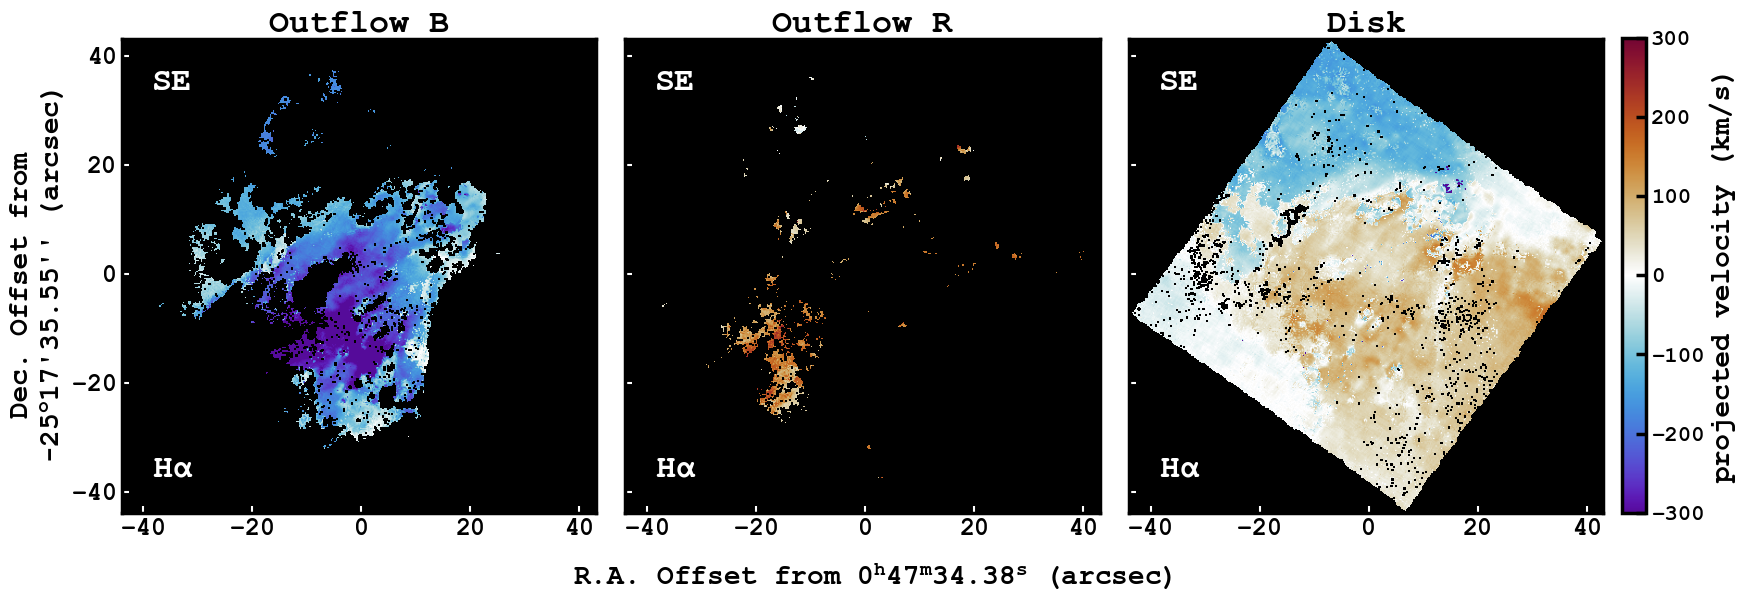

In [23]:
# cmap = 'turbo'
cmap = cmr.get_sub_cmap('cmr.fusion_r', 0.1, 0.90)
# cmap = cmr.fusion_r
# cmap = cmr.redshift
# cmap = cmr.infinity
# cmap = cmr.tropical_r
# cmap = 'rainbow'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# BLUESHIFTED OUTFLOW
im = ax1.imshow(outflow1_vel, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=extent)
# ax1.plot(183,212, 's',color='yellow',ms=20)
ax1.set_title('Outflow B', fontsize=24)
ax1.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax1.set_facecolor('black')

at = AnchoredText('H$\\alpha$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
ax1.set_ylabel('Dec. Offset from \n%s (arcsec)' % dec_dms, fontsize=20)
ax1.set_yticks([-40, -20, 0, 20, 40])


im = ax2.imshow(outflow2_vel, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=extent) #vmin=vmin, vmax=vmax, cmap='rainbow')
ax2.set_title('Outflow R', fontsize=24)
ax2.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax2.set_facecolor('black')

at = AnchoredText('H$\\alpha$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)


im = ax3.imshow(disk_vel, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=extent)#vmin=vmin, vmax=vmax, origin='lower', cmap='rainbow')
ax3.set_title('Disk', fontsize=24)
ax3.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax3.set_facecolor('black')

at = AnchoredText('H$\\alpha$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)

cax = ax3.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax3, cax=cax)
bar.set_label('projected velocity (km/s)', fontsize=20)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=20, family='courier new', weight='bold', style='normal')
plt.tight_layout()
plt.subplots_adjust(wspace=-0.3, hspace=0)
# plt.savefig('../../ngc253/muse/visuals/se_vels_Ha.png',bbox_inches='tight', dpi=200)

In [24]:
np.mean(outflow1_vel[np.isfinite(outflow1_vel)])

-166.20080359048313

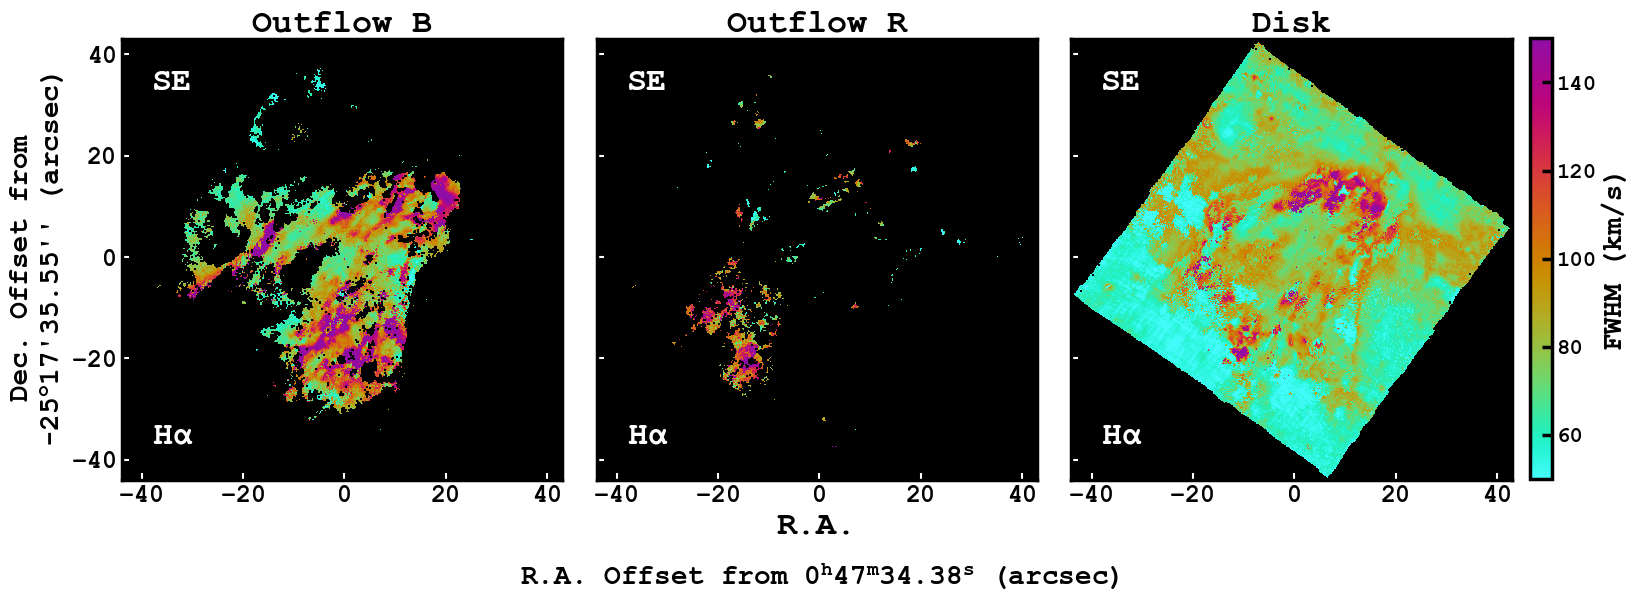

In [11]:
cmap = cmr.tropical_r
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

vmin=50
vmax=150

# BLUESHIFTED OUTFLOW
im = ax1.imshow(outflow1_fwhm * 2.355, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=extent)
ax1.set_title('Outflow B', fontsize=24)
ax1.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax1.set_facecolor('black')

at = AnchoredText('H$\\alpha$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
ax1.set_ylabel('Dec. Offset from \n%s (arcsec)' % dec_dms, fontsize=20)
ax1.set_yticks([-40, -20, 0, 20, 40])

im = ax2.imshow(outflow2_fwhm * 2.355, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=extent) #vmin=vmin, vmax=vmax, cmap='rainbow')
ax2.set_title('Outflow R', fontsize=24)
ax2.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax2.set_xlabel('R.A.', fontsize=24)
ax2.set_facecolor('black')

at = AnchoredText('H$\\alpha$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)


im = ax3.imshow(disk_fwhm * 2.355, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=extent)#vmin=vmin, vmax=vmax, origin='lower', cmap='rainbow')
ax3.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax3.set_facecolor('black')

at = AnchoredText('H$\\alpha$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
ax3.set_title('Disk', fontsize=24)

cax = ax3.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax3, cax=cax)
bar.set_label('FWHM (km/s)', fontsize=20)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=20, family='courier new', weight='bold', style='normal')
plt.tight_layout()
plt.subplots_adjust(wspace=-0.4, hspace=0)
# plt.savefig('../../ngc253/muse/visuals/se_fwhm_Ha.png',bbox_inches='tight', dpi=200)

In [12]:
print(np.median(disk_sig[np.isfinite(disk_sig)]))
print(np.mean(disk_sig[np.isfinite(disk_sig)]))

71.90527337336603
74.77567537248669


Write everything to file to then be used for analysis in other notebooks.

In [13]:
hdu.header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  437 / length of data axis 1                          
NAXIS2  =                  436 / length of data axis 2                          
NAXIS3  =                 3801 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
DATASUM = '2086791948'         / data unit checksum updated 2018-11-22T21:20:49 
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'  

In [27]:
# make the header
cube = SpectralCube.read('../../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits', hdu=1)  
hdr = cube.header
hdr['CUNIT3'] = 'km s-1'
hdr['CTYPE3'] = ('VOPT-W2W', 'Optical velocity (linear)')
hdr

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3                                                  
NAXIS1  =                  437                                                  
NAXIS2  =                  436                                                  
NAXIS3  =                 3801                                                  
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
DATASUM = '2086791948'         / data unit checksum updated 2018-11-22T21:20:49 
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'  

In [28]:
outflow1_vel[np.isfinite(outflow1_vel)]

array([ -41.49782516,  -17.08428313, -137.18918935, ..., -192.39538613,
       -264.83219727, -160.38298894])

In [29]:
outflow1_amp[np.isfinite(outflow1_amp)]

array([ 80.4066, 205.0613,  21.8526, ...,  93.319 ,  64.105 ,  86.284 ])

In [30]:
hdul = fits.PrimaryHDU(data=disk_vel, header=hdr)
hdul.writeto('../../ngc253/muse/data/output_maps/ngc253_muse_se_ha_vel_disk.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow1_vel, header=hdr)
hdul.writeto('../../ngc253/muse/data/output_maps/ngc253_muse_se_ha_vel_outflow_blue.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow2_vel, header=hdr)
hdul.writeto('../../ngc253/muse/data/output_maps/ngc253_muse_se_ha_vel_outflow_red.fits',  overwrite=True)



hdul = fits.PrimaryHDU(data=disk_amp, header=hdr)
hdul.writeto('../../ngc253/muse/data/output_maps/ngc253_muse_se_ha_amp_disk.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow1_amp, header=hdr)
hdul.writeto('../../ngc253/muse/data/output_maps/ngc253_muse_se_ha_amp_outflow_blue.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow2_amp, header=hdr)
hdul.writeto('../../ngc253/muse/data/output_maps/ngc253_muse_se_ha_amp_outflow_red.fits',  overwrite=True)


hdul = fits.PrimaryHDU(data=disk_sig, header=hdr)
hdul.writeto('../../ngc253/muse/data/output_maps/ngc253_muse_se_ha_sig_disk.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow1_sig, header=hdr)
hdul.writeto('../../ngc253/muse/data/output_maps/ngc253_muse_se_ha_sig_outflow_blue.fits',  overwrite=True)

hdul = fits.PrimaryHDU(data=outflow2_sig, header=hdr)
hdul.writeto('../../ngc253/muse/data/output_maps/ngc253_muse_se_ha_sig_outflow_red.fits',  overwrite=True)
